In [1]:
import torch
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

from noise import pnoise3
from PIL import Image
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from transformers import pipeline

/home/luisa/anaconda3/envs/test2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LORA_MODEL_PATH ="weights/dense_fog_lora"
DEPTHMAP_FILEPATH =  "samples/00000440_depth_front.png"

NEGATIVE_PROMPT="monochrome, lowres, unrealistic, worst quality, low quality, cartoon, painting, drawing, digital art, black and white"
PROMPT = "streetscape, dense fog, high quality photography, Canon EOS R3, street, natural lighting, detailed shadows, 35 mm lens"

In [3]:
def load_depth_map (depthmap_filepath, size = 512):
    
    size = size
    filepath = depthmap_filepath
    
    depth_map = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    B, G, R = cv2.split(depth_map)
    depth_map = 255.0 / ( (256 * 256 * B + 256 * G + R) / (256 * 256 * 256 - 1) * 500 )
    depth = cv2.resize(depth_map, (size,size), interpolation=cv2.INTER_AREA).astype(np.uint8)
    depth = Image.fromarray(depth)
    
    return depth

/home/luisa/anaconda3/envs/test2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|█████████████| 6/6 [00:00<00:00,  6.92it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.

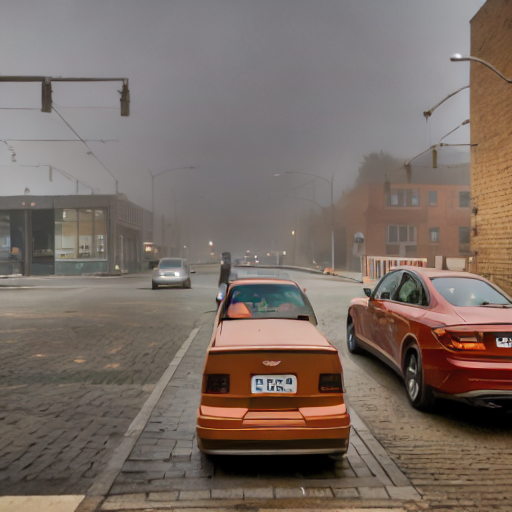

In [4]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.load_lora_weights(LORA_MODEL_PATH)
pipe.to("cuda")


depth = load_depth_map(DEPTHMAP_FILEPATH)

output_image = pipe(PROMPT, depth, negative_prompt=NEGATIVE_PROMPT, num_inference_steps=50).images[0]

output_image

## Fog Simulator: FoHIS Method

In [77]:
# Visibility range of molecules in meters
molecule_visibility = 12
# Visibility range of aerosols in meters
aerosol_visibility = 450
# Coefficients
ECM = 3.912 / molecule_visibility
ECA = 3.912 / aerosol_visibility
# FOG_TOP m
FT = 70
# HAZE_TOP m
HT = 34
# These parameters are set based for road-scenes based images
CAMERA_ALTITUDE = 1.6
fov = 64

In [78]:
img = 'Fog_Simulator-FoHIS/Results/Shift_Images/image_34e4-52a5_00000000_img_front.jpg'
Ip = cv2.imread(img)

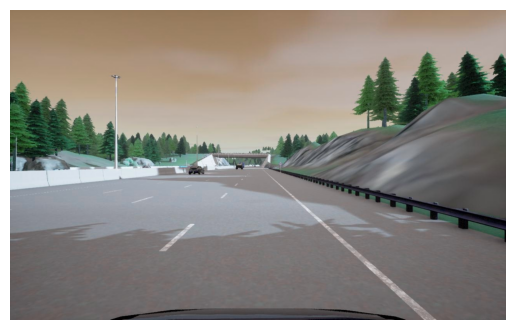

In [79]:
plt.imshow(cv2.cvtColor(Ip, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

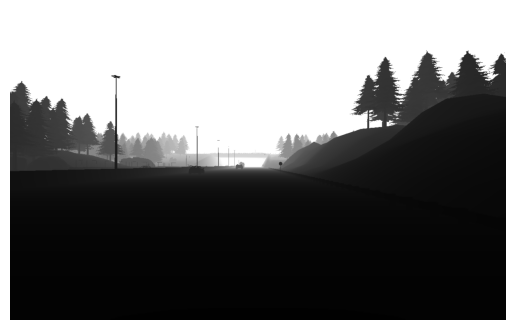

In [80]:
img_d = 'Fog_Simulator-FoHIS/Results/Shift_Depth-Maps/depth_34e4-52a5_00000000_img_front.png'
Dp = cv2.imread(img_d)
plt.imshow(cv2.cvtColor(Dp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [81]:
depth = cv2.imread('Fog_Simulator-FoHIS/Results/Shift_Depth-Maps/depth_34e4-52a5_00000000_img_front.png')[:, :, 0].astype(np.float64)
depth[depth==0] = 1
depth *= 3

In [82]:
I = np.empty_like(Ip)
result = np.empty_like(Ip)

In [83]:
def get_image_info(src):
    im = Image.open(src)
    try:
        dpi = im.info['dpi']
    except KeyError:
        dpi = (72, 72)
    return dpi

In [84]:
def elevation_and_distance_estimation(src, depth, vertical_fov, camera_altitude):
    # Load the image and get its DPI
    img = cv2.imread(src)
    img_dpi = get_image_info(src)

    height, width = img.shape[:2]
    altitude = np.empty((height, width))
    distance = np.empty((height, width))
    angle = np.empty((height, width))
    depth_min = depth.min()

    for j in range(width):
        for i in range(height):
            # theta is the vertical angle
            theta = i / (height - 1) * vertical_fov
            # Case: theta is less than half of the vertical FOV
            if theta < 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(0.5 * vertical_fov - theta))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (0.5*height-i)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = camera_altitude+depth[i, j]*y1/depth_min
                angle[i, j] = 0.5 * vertical_fov - theta
            # Case: theta is half of the vertical FOV
            elif theta == 0.5 * vertical_fov:
                distance[i, j] = depth[i, j]
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = 0
            # Case: theta is greater than half of the vertical FOV
            elif theta > 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(theta-0.5*vertical_fov))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = -(theta - 0.5 * vertical_fov)
    return altitude, distance, angle

In [85]:
elevation, distance, angle = elevation_and_distance_estimation(img, depth, fov, CAMERA_ALTITUDE)

In [86]:
def noise(Ip, depth):
    # Initialize three grayscale images
    p1 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p2 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p3 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    # Scales for noise generation
    scales = [1/130.0, 1/60.0, 1/10.0]
    # Generate noise
    for i, scale in enumerate(scales):
        for y in range(Ip.shape[0]):
            for x in range(Ip.shape[1]):
                # Generate Perlin noise
                v = pnoise3(x * scale, y * scale, depth[y, x] * scale, octaves=1, persistence=0.5, lacunarity=2.0)
                color = int((v + (1.2 if i == 2 else (0.5 if i == 1 else 1)))*128)
                if i == 0:
                    p1.putpixel((x, y), color)
                elif i == 1:
                    p2.putpixel((x, y), color)
                elif i == 2:
                    p3.putpixel((x, y), color)
    # Final perlin noise
    perlin = (np.array(p1) + np.array(p2) / 2 + np.array(p3) / 4) / 3
    return perlin

In [87]:
perlin = noise(Ip, depth)
c = (1-elevation/(FT+0.00001))
c[c<0] = 0
ECM = (ECM * c + (1-c)*ECA) * (perlin/255)

In [88]:
distance_through_fog = np.zeros_like(distance)
distance_through_haze = np.zeros_like(distance)
distance_through_haze_free = np.zeros_like(distance)

In [89]:
idx1 = (np.logical_and(FT > elevation, elevation > HT))
idx2 = elevation <= HT
idx3 = elevation >= FT

distance_through_haze[idx2] = distance[idx2]
distance_through_fog[idx1] = (elevation[idx1] - HT) * distance[idx1] / (elevation[idx1] - CAMERA_ALTITUDE)
distance_through_haze[idx1] = distance[idx1] - distance_through_fog[idx1]
distance_through_haze[idx3] = (HT - CAMERA_ALTITUDE) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_fog[idx3] = (FT - HT) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_haze_free[idx3] = distance[idx3] - distance_through_haze[idx3] - distance_through_fog[idx3]

I[:, :, 0] = Ip[:, :, 0] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 1] = Ip[:, :, 1] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 2] = Ip[:, :, 2] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
O = 1-np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)

In [93]:
Ial = np.empty_like(Ip)
Ial[:, :, 0] = 201  # R
Ial[:, :, 1] = 225  # G
Ial[:, :, 2] = 225  # B

In [94]:
result[:, :, 0] = I[:, :, 0] + O * Ial[:, :, 0]  # R
result[:, :, 1] = I[:, :, 1] + O * Ial[:, :, 1]  # G
result[:, :, 2] = I[:, :, 2] + O * Ial[:, :, 2]  # B

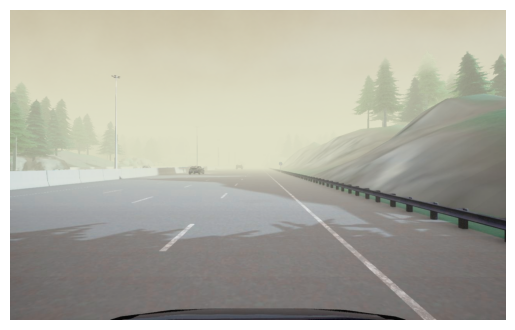

In [95]:
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()